# Hyperparameter Optimization with Optuna

With great models, comes the great problem of optimizing hyper-parameters {cite}`AAAMLP`. Once a good search algorithm is established for hyperparameter optimization, the task becomes an engineering problem [^ref]. Hence, we will explore an open-source library that offers a framework for solving this task. 

[^ref]: Like all applied machine learning solutions.

<br>

```{figure} ../img/optuna.png
---
width: 30em
name: optuna
---
```

> **Optuna** is an automatic hyperparameter optimization software framework, particularly designed for machine learning. It features an imperative, *define-by-run* style user API. Thanks to our *define-by-run* API, the code written with Optuna enjoys high modularity, and the user of Optuna can dynamically construct the search spaces for the hyperparameters.


- [Optuna FAQ](https://optuna.readthedocs.io/en/stable/faq.html)
- [Optuna docs](https://optuna.readthedocs.io/en/stable/index.html#)

## Basics with scikit-learn

Optuna is a black-box optimizer, which means it only needs an objective function, which is any function that returns a numerical value, to evaluate the performance of the its parameters, and decide where to sample in upcoming trials. An optimization problem is framed in the Optuna API using two basic concepts: `study` and `trial`. 

A study is conceptually an optimization based on an objective function, while a trial is a single execution of an objective function. The combination of hyperparameters for each trial is sampled according to some sampling algorithm defined by the study. Optuna uses  **Tree-structured Parzen Estimater** (TPE) {cite}`bergstra`, which is a form of Bayesian optimization, as the default sampler.

In the following code example, the search space is constructed within imperative Python code, e.g. inside conditionals or loops. On the other hand, recall that for `GridSearchCV` and `RandomSearchCV` in scikit-learn, we had to define the entire search space before running the search algorithm.

````{margin}
```{tip}
Always perform model evaluation on a dataset within a cross-validation framework!
```
````

In [1]:
import optuna
import pandas as pd
from sklearn import ensemble, svm
from sklearn import datasets
from sklearn import model_selection
from functools import partial
import joblib


# [1] Define an objective function to be maximized.
def objective(trial, X, y):
    
    # [2] Suggest values for the hyperparameters using trial object.
    clf_name = trial.suggest_categorical('classifier', ['SVC', 'RandomForest'])
    if clf_name == 'SVC':
        svc_c = trial.suggest_loguniform('svc_c', 1e-10, 1e10)
        clf = svm.SVC(C=svc_c, gamma='auto')
    else:
        rf_max_depth = int(trial.suggest_loguniform('rf_max_depth', 2, 32))
        clf = ensemble.RandomForestClassifier(max_depth=rf_max_depth, n_estimators=10)

    score = model_selection.cross_val_score(clf, X, y, n_jobs=-1, cv=5)
    return score.mean()

# [3] Create a study object and optimize the objective function.
X, y = datasets.load_breast_cancer(return_X_y=True, as_frame=True)
study = optuna.create_study(direction="maximize")
study.optimize(partial(objective, X=X, y=y), n_trials=20)

[I 2021-09-18 00:54:16,888] A new study created in memory with name: no-name-a09e8270-0737-4ade-9caf-47af4159372b
[I 2021-09-18 00:54:21,647] Trial 0 finished with value: 0.6274181027790716 and parameters: {'classifier': 'SVC', 'svc_c': 0.0003643378047804461}. Best is trial 0 with value: 0.6274181027790716.
[I 2021-09-18 00:54:22,197] Trial 1 finished with value: 0.933224654556746 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 2.2456514603944764}. Best is trial 1 with value: 0.933224654556746.
[I 2021-09-18 00:54:22,389] Trial 2 finished with value: 0.9525694767893185 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 4.372106941485736}. Best is trial 2 with value: 0.9525694767893185.
[I 2021-09-18 00:54:22,566] Trial 3 finished with value: 0.9560937742586555 and parameters: {'classifier': 'RandomForest', 'rf_max_depth': 31.255003510122748}. Best is trial 3 with value: 0.9560937742586555.
[I 2021-09-18 00:54:22,707] Trial 4 finished with value: 0.62741810277

The `study` object saves the result of evaluating the objective each trial &mdash; which is essentially some choice of hyperparameters to evaluate. In the above study, the problem of model selection is framed as a hyperparameter optimization problem. Here we choose between an SVM-based algorithm or Random Forest.

In [2]:
study.trials_dataframe().head()

,number,value,datetime_start,datetime_complete,duration,params_classifier,params_rf_max_depth,params_svc_c,state
0,0,0.627418,2021-09-18 00:54:16.890659,2021-09-18 00:54:21.646724,0 days 00:00:04.756065,SVC,NaN,0.000364,COMPLETE
1,1,0.933225,2021-09-18 00:54:21.650019,2021-09-18 00:54:22.196979,0 days 00:00:00.546960,RandomForest,2.245651,NaN,COMPLETE
2,2,0.952569,2021-09-18 00:54:22.198708,2021-09-18 00:54:22.389621,0 days 00:00:00.190913,RandomForest,4.372107,NaN,COMPLETE
3,3,0.956094,2021-09-18 00:54:22.391213,2021-09-18 00:54:22.565850,0 days 00:00:00.174637,RandomForest,31.255004,NaN,COMPLETE
4,4,0.627418,2021-09-18 00:54:22.567458,2021-09-18 00:54:22.706474,0 days 00:00:00.139016,SVC,NaN,2161.678719,COMPLETE


### Fine tuning Random Forest

Here we focus on tuning a single Random Forest model. Then, plot the accuracy for each pair of hyperparameters.

In [13]:
def objective(trial):
    
    max_depth = trial.suggest_int('max_depth', 2, 128, log=True)    
    max_features = trial.suggest_float('max_features', 0.1, 1.0)    
    n_estimators = trial.suggest_int('n_estimators', 100, 800)
    
    clf = ensemble.RandomForestClassifier(
        max_depth=max_depth,
        n_estimators=n_estimators,
        max_features=max_features)   
    
    score = model_selection.cross_val_score(clf, X, y, n_jobs=-1, cv=5)
    return score.mean()


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=60)

[I 2021-09-17 11:34:14,544] A new study created in memory with name: no-name-be3ee317-698a-4c5d-9fe1-e757908aa439
[I 2021-09-17 11:34:18,969] Trial 0 finished with value: 0.9578636857630801 and parameters: {'max_depth': 44, 'max_features': 0.9353762762020692, 'n_estimators': 374}. Best is trial 0 with value: 0.9578636857630801.
[I 2021-09-17 11:34:22,197] Trial 1 finished with value: 0.95960254618848 and parameters: {'max_depth': 35, 'max_features': 0.2760512375498332, 'n_estimators': 527}. Best is trial 1 with value: 0.95960254618848.
[I 2021-09-17 11:34:24,061] Trial 2 finished with value: 0.9613724576929048 and parameters: {'max_depth': 18, 'max_features': 0.4158947791697736, 'n_estimators': 245}. Best is trial 2 with value: 0.9613724576929048.
[I 2021-09-17 11:34:28,588] Trial 3 finished with value: 0.9631423691973294 and parameters: {'max_depth': 84, 'max_features': 0.6870740052981664, 'n_estimators': 471}. Best is trial 3 with value: 0.9631423691973294.
[I 2021-09-17 11:34:32,690

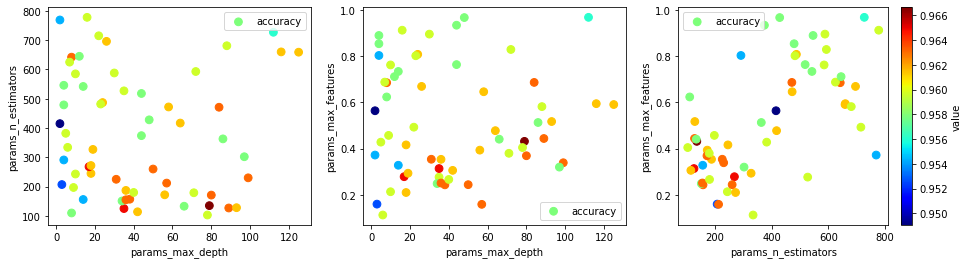

In [14]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=3)

def plot_results(study, p1, p2, j, cb):
    study.trials_dataframe().plot(
        kind='scatter', ax=axes[j], x=p1, y=p2,
        c='value', s=60, cmap=plt.get_cmap("jet"), 
        colorbar=cb, label="accuracy", figsize=(16, 4)
    )

plot_results(study, 'params_max_depth', 'params_n_estimators', j=0, cb=False)
plot_results(study, 'params_max_depth', 'params_max_features', j=1, cb=False)
plot_results(study, 'params_n_estimators', 'params_max_features', j=2, cb=True);

**Figure.** TPE in action. Observe that the hyperparameter space is searched more efficiently than a random search with the sampler choosing points closer to previous good results. Samplers are specified when creating a study: 

```python
study = create_study(direction="maximize", sampler=optuna.samplers.TPESampler())
```

Optuna also implements our old friends random and grid search with the following samplers:
- `optuna.samplers.GridSampler`
- `optuna.samplers.RandomSampler`

The best parameters can be obtained using:

In [15]:
study.best_params

{'max_depth': 79, 'max_features': 0.4312282751175512, 'n_estimators': 135}

### Visualization: TPE

Optuna provides visualization functions in the `optuna.visualization` library. The following plot shows the best objective value found as the trials progress. The increasing trend in accuracies found tells us that the TPE sampler is working well, i.e. the search algorithm learns from past trials. Low scores on trials 37 and 45 indicate that the sampler still performs some exploration even after many trials. 

In [ ]:
optuna.visualization.plot_optimization_history(study)

```{figure} ../img/optuna-1.png
---
name: optuna-1
---
```

The **parallel coordinate plot** can give us a feel of how the hyperparameters interact. The `params` parameter allow us to consider only a subset of the suggested hyperparameters. For instance, if `max_features` is between 0.6 and 0.8, then `max_depth` should be lower, around 4 to 32. Moreover, `n_estimators` should be between 500 and 700. On the other hand, the strongest choice of hyperparameters, uses only a few trees with `n_estimators=135`, but with high depth `max_depth=79` [^ref2]. 


[^ref2]: The choice looks more like an outlier compared to other samples. Perhaps narrowing down the search space to this area would provide us more evidence regarding the robustness of this choice, or increasing the number of trials.

In [ ]:
optuna.visualization.plot_parallel_coordinate(study, params=['n_estimators', 'max_depth', 'max_features'])

```{figure} ../img/optuna-2.png
---
name: optuna-2
---
```

**Slice plots** project the path of the optimizer in the hyperparameter space on each hyperparameter dimension. A large spread of dark dots indicate that a large range of values of that hyperparameter is feasible even at later stages. Lower spread tend to indicate less importance. For example, `n_estimators` has smaller spread, and is the least important hyperparameter. That is, the sampler focuses on a small region of the search space for this parameter at later stages into the optimization.

In [ ]:
optuna.visualization.plot_slice(study, params=['n_estimators', 'max_depth', 'max_features'])

```{figure} ../img/optuna-3.png
---
name: optuna-3
---
```

Indeed, the **parameter importance plot** below supports this. The default hyperparameter importance evaluator is `optuna.importance.FanovaImportanceEvaluator` which implements fANOVA importance {cite}`pmlr-v32-hutter14`. This takes as input performance data gathered with different hyperparameter settings of the algorithm, fits a random forest to capture the relationship between hyperparameters and performance, and then applies functional ANOVA to assess how important each of the hyperparameters and each low-order interaction of hyperparameters is to performance. See the paper for more details on fANOVA.

> The performance of fANOVA depends on the prediction performance of the underlying random forest model. In order to obtain high prediction performance, it is necessary to cover a wide range of the hyperparameter search space. It is recommended to use an exploration-oriented sampler such as `RandomSampler`.



In [ ]:
optuna.visualization.plot_param_importances(study)

```{figure} ../img/optuna-4.png
---
name: optuna-4
---
```

To visualize interactions of any pair of hyperparameters, we use **contour plots.** The contour plots indicate regions of high objective value.

In [ ]:
fig = optuna.visualization.plot_contour(study, params=["max_depth", "n_estimators"])
fig.update_layout(autosize=False, width=550, height=500)
fig.show()

```{figure} ../img/optuna-5.png
---
name: optuna-5
---
```

### Visualization: Random Search

Let us look at the contour plot for **random search**. Recall that `max_depth` is sampled logarithmically from 2 to 32. Observe that the sampler spends a lot of resources around areas with low objective value. This is in contrast to the TPE sampler above, which tries to probe specific regions of the space despite the range for `max_depth` being logarithmic.

In [4]:
# Search best params using random sampler
study_random = optuna.create_study(direction="maximize", sampler=optuna.samplers.RandomSampler())
study_random.optimize(objective, n_trials=50)

# Plot contour
fig = optuna.visualization.plot_contour(study_random, params=["max_depth", "n_estimators"])
fig.update_layout(autosize=False, width=550, height=500)
fig.show()

[I 2021-09-18 00:54:56,104] A new study created in memory with name: no-name-a6510970-98c7-4b65-ae2b-1fd0f4b307b2
[I 2021-09-18 00:55:10,437] Trial 0 finished with value: 0.9561092997981678 and parameters: {'max_depth': 37, 'max_features': 0.9275697884124803, 'n_estimators': 506}. Best is trial 0 with value: 0.9561092997981678.
[I 2021-09-18 00:55:20,101] Trial 1 finished with value: 0.9508150908244062 and parameters: {'max_depth': 2, 'max_features': 0.719969519036332, 'n_estimators': 541}. Best is trial 0 with value: 0.9561092997981678.
[I 2021-09-18 00:55:24,326] Trial 2 finished with value: 0.9578481602235677 and parameters: {'max_depth': 8, 'max_features': 0.4670311499471149, 'n_estimators': 169}. Best is trial 2 with value: 0.9578481602235677.
[I 2021-09-18 00:55:43,029] Trial 3 finished with value: 0.9578636857630801 and parameters: {'max_depth': 9, 'max_features': 0.7984617026525599, 'n_estimators': 733}. Best is trial 3 with value: 0.9578636857630801.
[I 2021-09-18 00:55:48,678

```{figure} ../img/optuna-6.png
---
name: optuna-6
---
```

Moreover, there is no increasing trend in the objective values of each trial as the search progresses.

In [6]:
optuna.visualization.plot_optimization_history(study_random)

```{figure} ../img/optuna-6a.png
---
name: optuna-6a
---
```

## Neural Networks

As noted above, we should always perform tuning within a cross-validation framework. However, with neural networks, doing 5-fold CV would require too much compute time &mdash; hence, too much resources, e.g. GPU usage. Instead, we perform tuning on a hold-out validation set and hope for the best. 

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader

from sklearn import model_selection
from sklearn.datasets import fetch_openml

from tqdm import tqdm
import numpy as np
from pathlib import Path
import datetime

Define a simple network.

In [24]:
class Model(nn.Module):
    """Neural network with one hidden layer."""
    
    def __init__(self, input_size, num_classes, hidden_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

We also define a `Dataset` class for MNIST.

In [25]:
class MNISTDataset(Dataset):
    def __init__(self, features, targets, transform=None):
        self.features = features
        self.targets = targets
        self.transform = transform
        
    def __len__(self):
        return self.features.shape[0]
    
    def __getitem__(self, i):
        X = self.features[i, :]
        y = self.targets[i]
        
        if self.transform is not None:
            X = self.transform(X)
            
        return X, y

Define a trainer for the neural network model. This will handle all loss and metric evaluation, as well as backpropagation.

In [26]:
class Engine:
    """Neural network trainer."""
    
    def __init__(self, model, device, optimizer):
        self.model = model
        self.device = device
        self.optimizer = optimizer 

    @staticmethod
    def loss_fn(outputs, targets):
        return nn.CrossEntropyLoss()(outputs, targets)
        
    def train(self, data_loader):
        """Train model on one epoch. Return train loss."""
        
        self.model.train()
        loss = 0
        for i, (data, targets) in enumerate(data_loader):
            data = data.to(self.device).reshape(data.shape[0], -1).float()
            targets = targets.to(self.device).long()
            
            # Forward pass
            outputs = self.model(data)
            J = self.loss_fn(outputs, targets)
            
            # Backward pass
            self.optimizer.zero_grad()
            J.backward()
            self.optimizer.step()

            # Cumulative loss
            loss += (J.detach().item() - loss) / (i + 1)

        return loss


    def eval(self, data_loader):
        """Return validation loss and validation accuracy."""
        
        self.model.eval()
        num_correct = 0
        num_samples = 0
        loss = 0.0
        with torch.no_grad():
            for i, (data, targets) in enumerate(data_loader):
                data = data.to(self.device).float()
                targets = targets.to(self.device)
                
                # Forward pass
                data = data.reshape(data.shape[0], -1)
                out = self.model(data)
                J = self.loss_fn(out, targets)
                _, preds = out.max(dim=1)

                # Cumulative metrics
                loss += (J.detach().item() - loss) / (i + 1)
                num_correct += (preds == targets).sum().item()
                num_samples += preds.shape[0]

        acc = num_correct / num_samples
        return loss, acc

Some config and setup prior to training. We get the MNIST data from scikit-learn, then get a stratified hold-out set. Finally, transform the data to PyTorch tensors.

In [27]:
# Config
RANDOM_STATE = 42
device = 'cuda' if torch.cuda.is_available() else 'cpu'
EPOCHS = 100
PATIENCE = 5
LR_PATIENCE = 3

INPUT_SIZE = 784
NUM_CLASSES = 10

# Fetch data
MNIST = fetch_openml("mnist_784")
X = MNIST['data'].reshape(-1, 28, 28)
y = MNIST['target'].astype(int)

# Create folds
cv = model_selection.StratifiedKFold(n_splits=5)
trn_, val_ = next(iter(cv.split(X=X, y=y)))

# Get train and valid data loaders
train_dataset = MNISTDataset(X[trn_, :], y[trn_], transform=transforms.ToTensor())
valid_dataset = MNISTDataset(X[val_, :], y[val_], transform=transforms.ToTensor())

### Intermediate values

Finally, we set up the `study` instance and its objective function. We have four numerical hyperparameters, and one which chooses the optimizer to use. Recall that a good choice of optimizer will depend on the nature of the loss surface. During training, we perform early stopping on validation loss. If no new minimum val. loss is found after 5 epochs, then the minimum val. loss is returned as the objective [^ref3].

Each trial is pruned based on the minimum val. loss found as of the current epoch. That is, if the minimum val. loss does not improve too quickly, then the trial is pruned. Note that the pruner only gets to observe a decreasing function of the epochs. This can be seen on the plot below, i.e. the plots don't show the validation loss at each epoch. 

[^ref3]: This makes sense in actual practice, where we place a model checkpoint on the minimum val. loss where we save the best model parameters.

```{margin}
Below `getattr(optim, optimizer_name)` is the same as `optim.Adam` if `optimizer_name` is assigned `'Adam'` by the `suggest_categorical` function. See [`getattr()`](https://www.w3schools.com/python/ref_func_getattr.asp) and [`setattr()`](https://www.w3schools.com/python/ref_func_setattr.asp) which are useful when using Optuna. 
```

In [28]:
def objective(trial):
    
    # Suggest parameters
    hidden_size = trial.suggest_int('hidden_size', 64, 512, log=True)
    batch_size = trial.suggest_int('batch_size', 8, 512, log=True)
    lr_factor = trial.suggest_loguniform('lr_factor', 0.1, 1.0)
    learning_rate = trial.suggest_loguniform('lr', 1e-5, 1e-1)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop'])

    # Model and tools
    model = Model(INPUT_SIZE, NUM_CLASSES, hidden_size).to(device)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=learning_rate) 
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=lr_factor, patience=LR_PATIENCE)
    engine = Engine(model, device, optimizer)
    
    # Data loaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=True)
    
    # Start training
    best_loss = np.inf
    patience = PATIENCE
    loop = tqdm(range(EPOCHS), total=EPOCHS, leave=False)
    for epoch in loop:

        # Train and validation step
        train_loss = engine.train(train_loader)
        valid_loss, valid_acc = engine.eval(valid_loader)

        # Reduce learning rate
        if scheduler is not None:
            scheduler.step(valid_loss)
            
        # Early stopping
        if valid_loss < best_loss:
            best_loss = valid_loss
            patience = PATIENCE
        else:
            patience -= 1
            if patience == 0:
                break
    
        # Pruning unpromising trials
        trial.report(best_loss, step=epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()

    return best_loss

# Create and run optimization problem 
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

[I 2021-09-17 11:57:55,938] A new study created in memory with name: no-name-a3abe10e-663b-4197-b15c-1f65a3c7b636
[I 2021-09-17 11:58:54,471] Trial 0 finished with value: 0.18587507512158077 and parameters: {'hidden_size': 255, 'batch_size': 198, 'lr_factor': 0.38798542609488146, 'lr': 0.005538714916113422, 'optimizer': 'Adam'}. Best is trial 0 with value: 0.18587507512158077.
[I 2021-09-17 11:59:34,686] Trial 1 finished with value: 0.13661525396511276 and parameters: {'hidden_size': 259, 'batch_size': 150, 'lr_factor': 0.21817555567903676, 'lr': 0.0019237746114520095, 'optimizer': 'Adam'}. Best is trial 1 with value: 0.13661525396511276.
[I 2021-09-17 12:01:14,723] Trial 2 finished with value: 1.599560173078517 and parameters: {'hidden_size': 131, 'batch_size': 23, 'lr_factor': 0.28546458952097453, 'lr': 0.007636887101046398, 'optimizer': 'RMSprop'}. Best is trial 1 with value: 0.13661525396511276.
[I 2021-09-17 12:01:46,696] Trial 3 finished with value: 0.47894483756207845 and parame

Trials below either early stops (gradient descent is stuck) or gets pruned (unpromising, even if gradient descent continues). Note that pruning starts at Trial 5. The pruner needs to obtain some information regarding the behavior of the minimum validation loss, so no pruning at early trials. After a while, it starts to prune almost every trial. Explains why optimization history improves a lot during early trials, but improves rarely after 20 trials. 

In [ ]:
optuna.visualization.plot_intermediate_values(study)

```{figure} ../img/optuna-7.png
---
name: optuna-7
---
```

In [ ]:
optuna.visualization.plot_optimization_history(study)

```{figure} ../img/optuna-8.png
---
name: optuna-8
---
```

### Hyperparameter interactions

Here we can see Adam looks like the better optimizer for MNIST. A learning rate of 0.001 looks good, with hidden size of around 400. Finally, batch size of around 128 is recommended. These all seem reasonable choices. Since we only have a single hidden layer, we need a wide layer to get sufficient network expressivity. For example, having hidden of around 150, suffers from worse performance. However, it's possible to get a decent validation loss with small hidden size by using a small batch size, a small learning rate, and using RMSProp. 

In [ ]:
optuna.visualization.plot_parallel_coordinate(study)

```{figure} ../img/optuna-9.png
---
name: optuna-9
---
```

From the contour plot, we see that using low batch size, with high learning rate is not a good idea. That makes sense. We can continue this sort of analysis for any other pair of hyperparameters.

In [ ]:
fig = optuna.visualization.plot_contour(study, params=['hidden_size', 'batch_size', 'lr', 'lr_factor'])
fig.update_layout(autosize=False, width=1000, height=1000)
fig.show()

```{figure} ../img/optuna-10.png
---
name: optuna-10
---
```

In [ ]:
optuna.visualization.plot_param_importances(study)

```{figure} ../img/optuna-12.png
---
name: optuna-12
---
```

## Appendix: Hyperparameters of common models

<br>

```{figure} ../img/hyp.png
---
name: hyp
---
```

**RS**$^*$ implies random search should be better.